# Waymo Open Dataset Tutorial
+ Acknowledgement: https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial.ipynb

In [ ]:
from waymo_open_dataset.utils import dataset_pb2
import tensorflow.compat.v1 as tf

# tfrecord格式解析
file_path = "/opt/data/common/waymo_open_dataset_v_1_2_0/training/segment-16102220208346880_1420_000_1440_000_with_camera_labels.tfrecord"
dataset = tf.data.TFRecordDataset(file_path, compression_type="")
for frame_index, data in enumerate(dataset):
    frame = dataset_pb2.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    # frame里面存储了某一帧的所有数据
    # 接下来就是对frame进行操作
    # 提取图像，calibration，lidar, dynamic mask, ego pose等
    
    

In [ ]:
import os
import tensorflow.compat.v1 as tf
import numpy as np 
import itertools

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset 

load_dir = "/opt/data/common/waymo_open_dataset_v_1_2_0/training"
filenames = open("data/waymo_train_list.txt").read().splitlines()
filenames = [ f"{load_dir}/{f}.tfrecord" for f in filenames]
scene_id = 23
file = filenames[scene_id]
dataset = tf.data.TFRecordDataset(file, compression_type="")


In [3]:
print(open_dataset.LaserName.TOP)

1


In [4]:
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break

(range_images, camera_projections, _, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)

# print(frame.context)


In [5]:
for index, image in enumerate(frame.images):
    print(image.name)

1
2
4
3
5


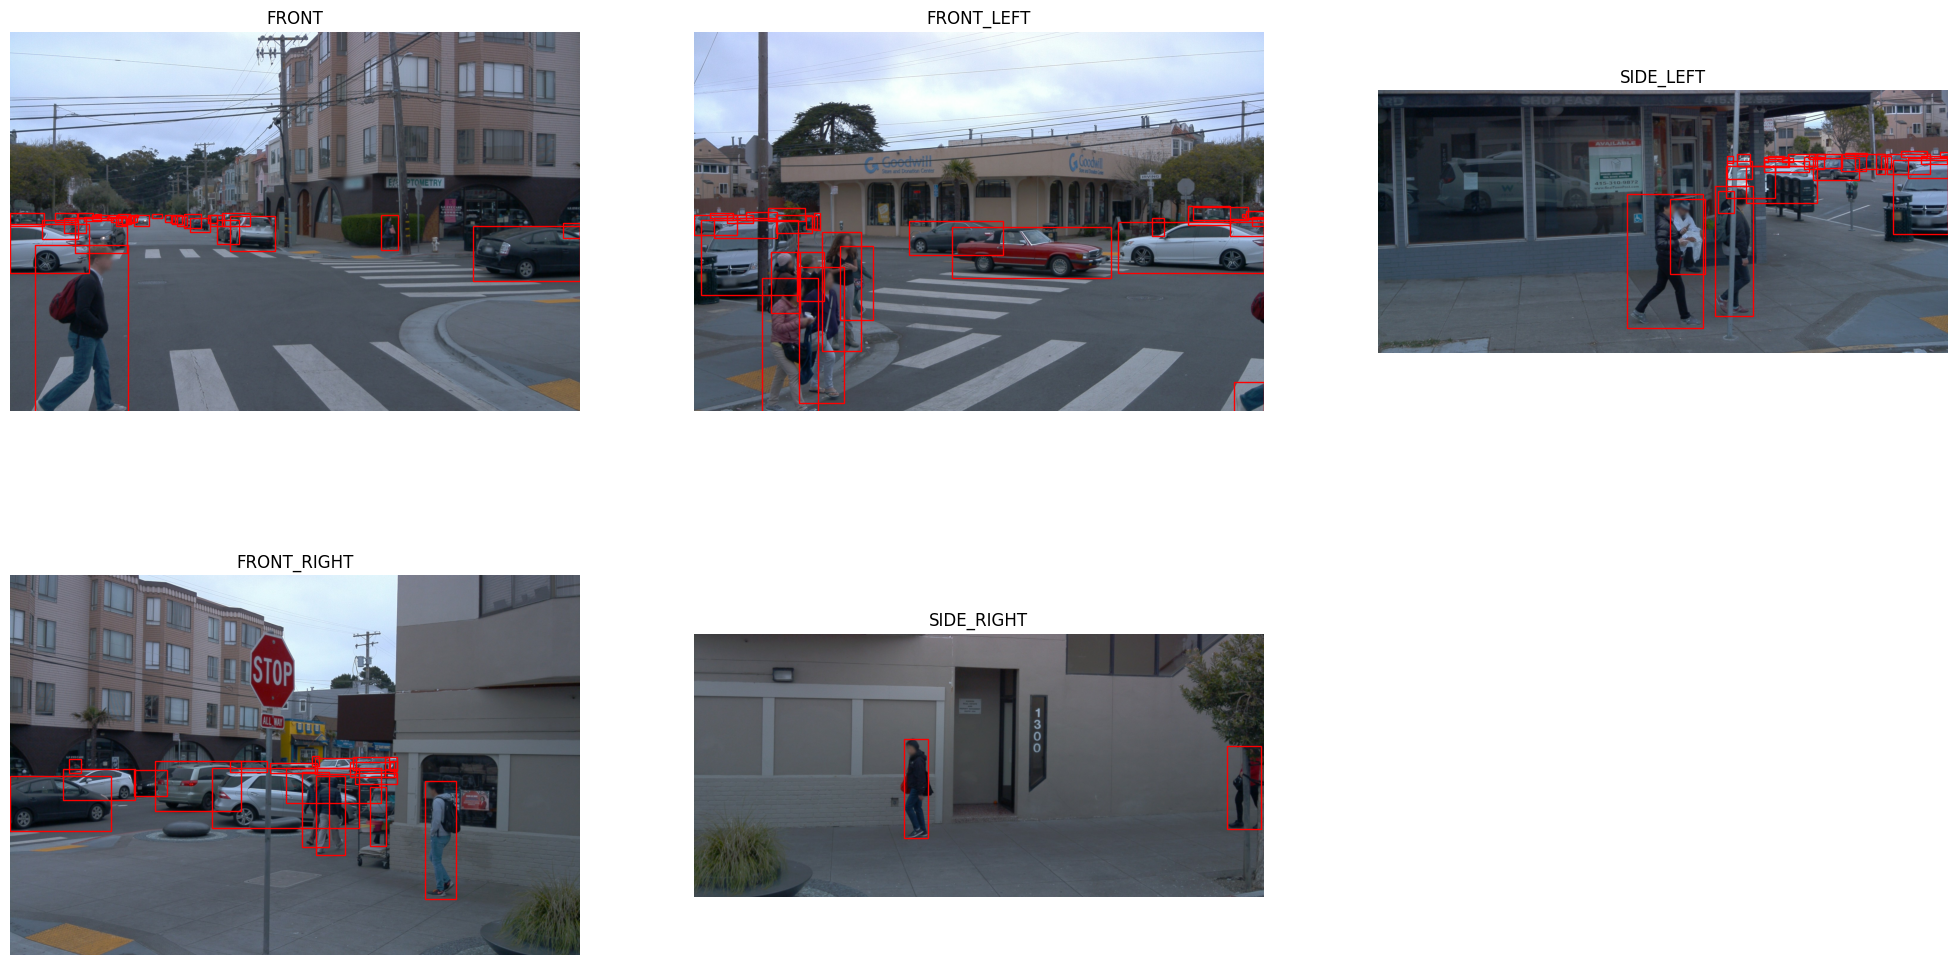

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_camera_image(camera_image, camera_labels, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  # Draw the camera labels.
  for camera_labels in frame.camera_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  show_camera_image(image, frame.camera_labels, [3, 3, index+1])

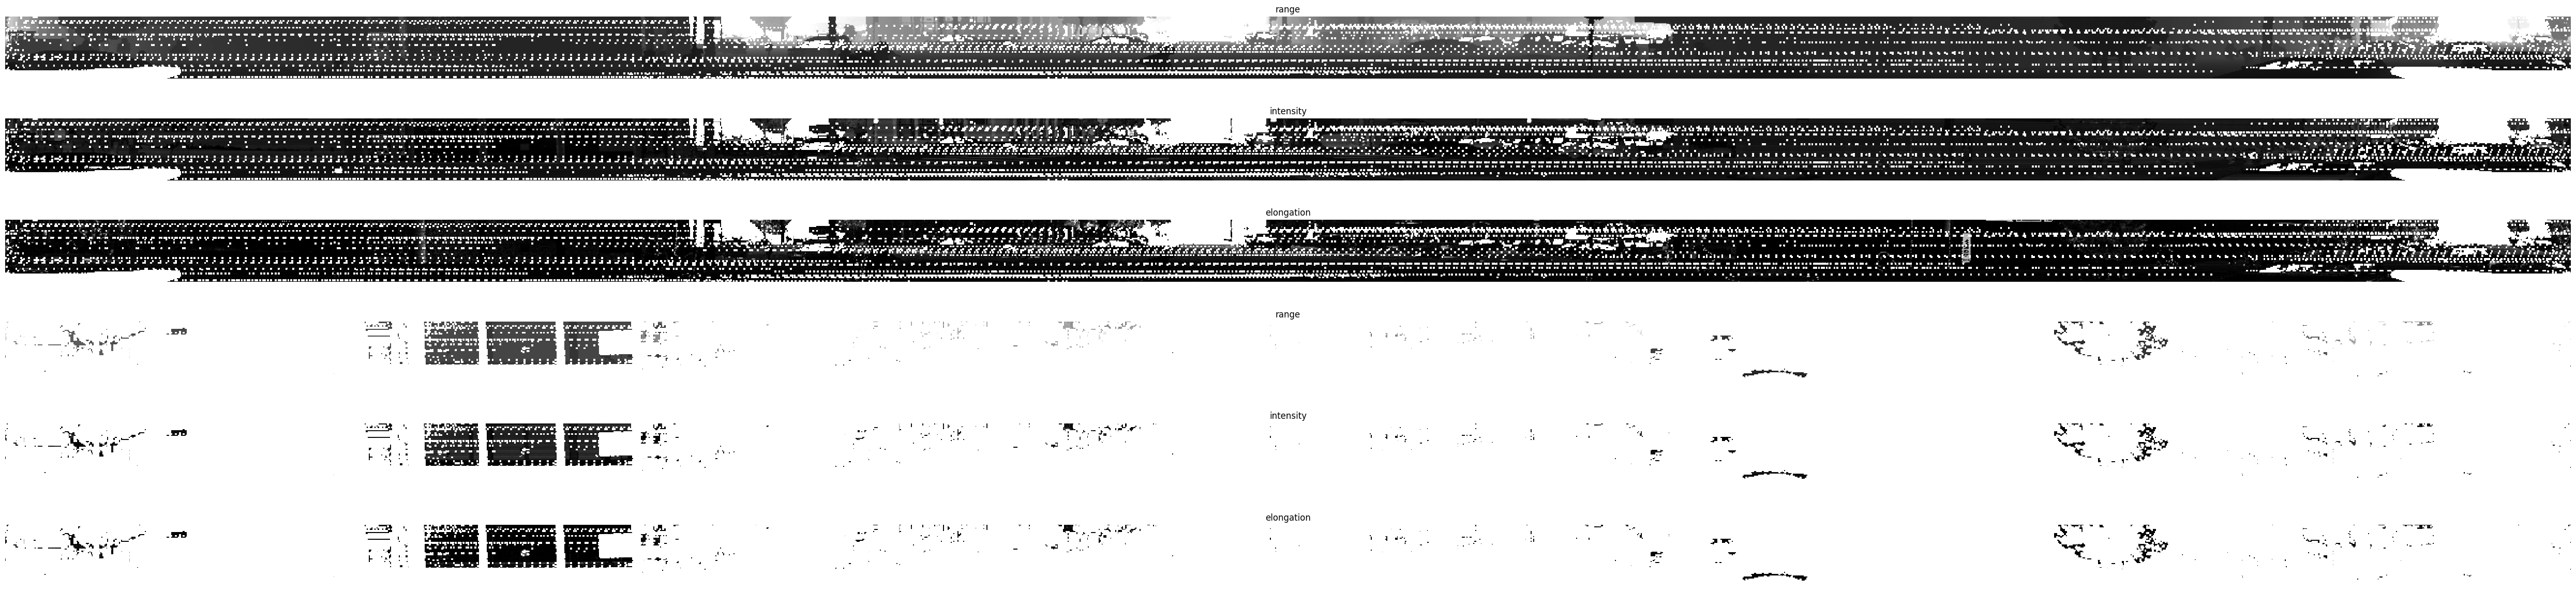

In [7]:
plt.figure(figsize=(64, 20))
def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
  """Plots range image.

  Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
  """
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_range_image(laser_name, return_index):
  """Returns range image given a laser name and its return index."""
  return range_images[laser_name][return_index]

def show_range_image(range_image, layout_index_start = 1):
  """Shows range image.

  Args:
    range_image: the range image data from a given lidar of type MatrixFloat.
    layout_index_start: layout offset
  """
  range_image_tensor = tf.convert_to_tensor(range_image.data)
  range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
  lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
  range_image_tensor = tf.where(lidar_image_mask, range_image_tensor,
                                tf.ones_like(range_image_tensor) * 1e10)
  range_image_range = range_image_tensor[...,0]
  range_image_intensity = range_image_tensor[...,1]
  range_image_elongation = range_image_tensor[...,2]
  plot_range_image_helper(range_image_range.numpy(), 'range',
                   [8, 1, layout_index_start], vmax=75, cmap='gray')
  plot_range_image_helper(range_image_intensity.numpy(), 'intensity',
                   [8, 1, layout_index_start + 1], vmax=1.5, cmap='gray')
  plot_range_image_helper(range_image_elongation.numpy(), 'elongation',
                   [8, 1, layout_index_start + 2], vmax=1.5, cmap='gray')
frame.lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 1), 4)

In [8]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)
     

2024-04-16 11:32:12.395197: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x2d5ab4b0


In [9]:

print(points_all.shape)
print(cp_points_all.shape)
print(points_all[0:2])
for i in range(5):
  print(points[i].shape)
  print(cp_points[i].shape)

(170372, 3)
(170372, 6)
[[-34.234375     0.04296875   3.6549683 ]
 [-34.007812     0.12890625   3.6453247 ]]
(151916, 3)
(151916, 6)
(3600, 3)
(3600, 6)
(4638, 3)
(4638, 6)
(4758, 3)
(4758, 6)
(5460, 3)
(5460, 6)


In [10]:

print(points_all_ri2.shape)
print(cp_points_all_ri2.shape)
print(points_all_ri2[0:2])
for i in range(5):
  print(points_ri2[i].shape)
  print(cp_points_ri2[i].shape)

(18442, 3)
(18442, 6)
[[-58.246094     0.21484375   4.6448975 ]
 [-57.625        0.3515625    4.6191406 ]]
(18219, 3)
(18219, 6)
(25, 3)
(25, 6)
(58, 3)
(58, 6)
(71, 3)
(71, 6)
(69, 3)
(69, 6)


In [11]:

images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

# The distance between lidar points and vehicle frame origin.
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[..., 0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat(
    [cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [12]:
def rgba(r):
  """Generates a color based on range.

  Args:
    r: the range value of a given point.
  Returns:
    The color for a given range
  """
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5  # alpha
  return c

def plot_image(camera_image):
  """Plot a cmaera image."""
  plt.figure(figsize=(20, 12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  plot_image(camera_image)

  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[0])  # width, col
    ys.append(point[1])  # height, row
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

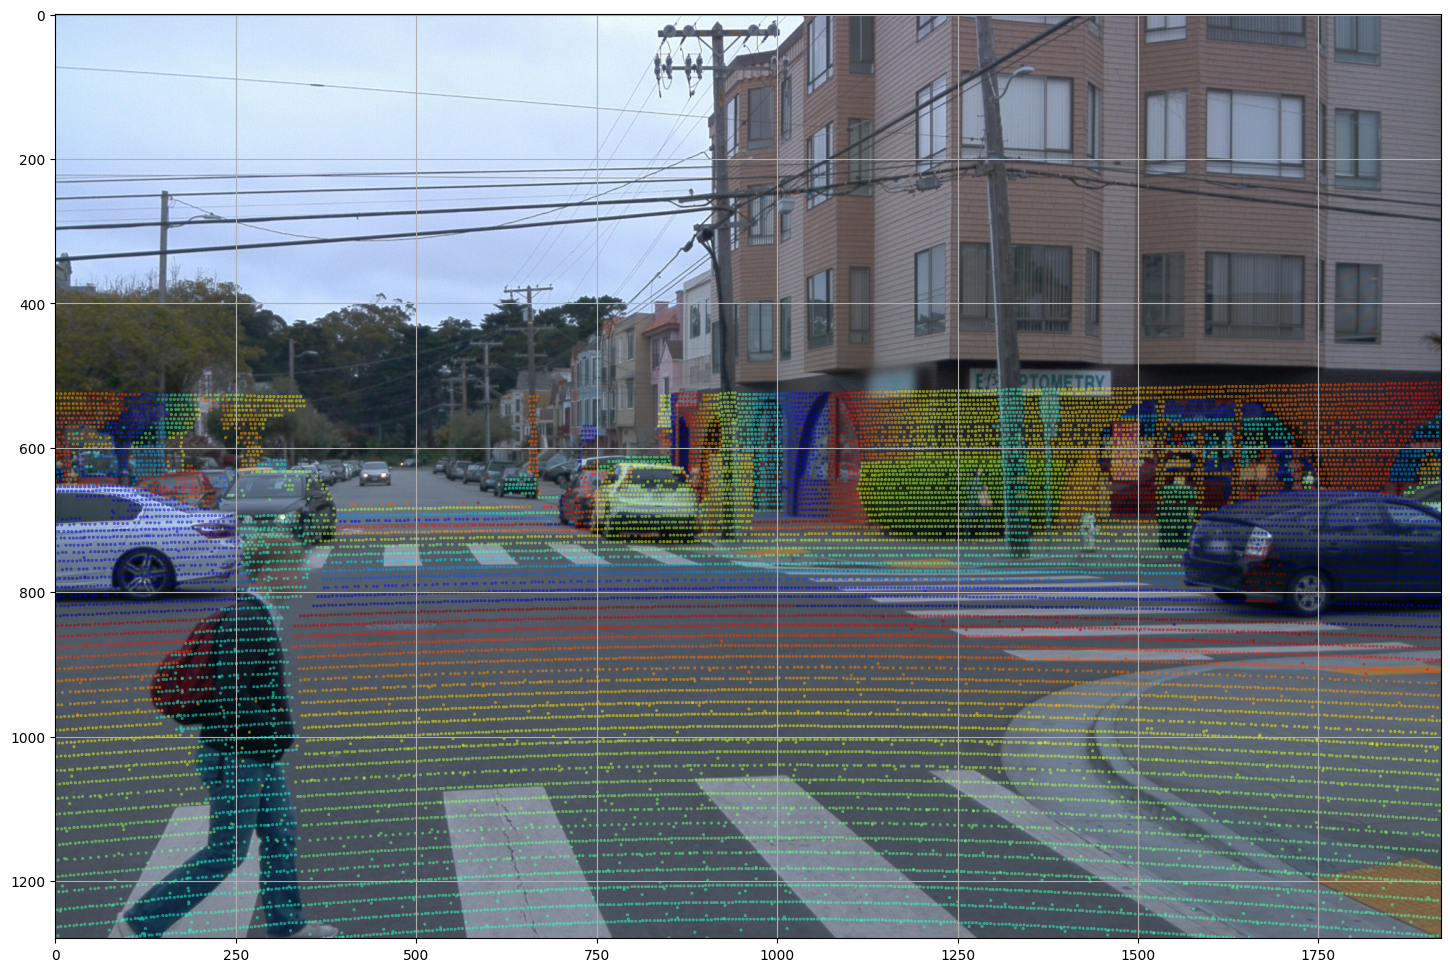

In [11]:

plot_points_on_image(projected_points_all_from_raw_data,
                     images[0], rgba, point_size=5.0)

In [8]:
import torch
x = torch.randn(10,4)
print(x.device)
x = x.to(device="cuda")
print(x.device)
b = torch.randn(10,4)
print(b.device)
b = b.to(x.device)
print(b.device)

cpu
cuda:0
cpu
cuda:0
